# Setup

## Import Library

In [1]:
import os
import asyncio
import nest_asyncio
import importlib
import time
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenetv3_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess
from tensorflow.keras import layers, models
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.optimizers import Adam
from PIL import Image
from dotenv import load_dotenv
from telegram import Bot, InputFile
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from tensorflow.keras.applications import (
    EfficientNetV2B0,
    EfficientNetV2B1,
    EfficientNetV2B2,
    EfficientNetV2B3,
    EfficientNetV2S,
    EfficientNetV2M,
    EfficientNetV2L
)

from efficientNet.efficientnet_v2_modifikasi import (
    EfficientNetV2B0Modifikasi,
    EfficientNetV2B1Modifikasi,
    EfficientNetV2B2Modifikasi,
    EfficientNetV2B3Modifikasi,
)

importlib.reload(importlib.import_module('efficientNet.efficientnet_v2_modifikasi'))

2025-01-05 12:11:34.520139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 12:11:34.533871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736079094.551636   42827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736079094.556993   42827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 12:11:34.575024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

<module 'efficientNet.efficientnet_v2_modifikasi' from '/workspace/TelU-Tubes-ProjectAkhir-BeanLeaf/efficientNet/efficientnet_v2_modifikasi.py'>

In [2]:
def reload():
    importlib.reload(importlib.import_module('efficientNet.efficientnet_v2_modifikasi'))

## Bot Telegram

In [3]:
# setup loop
nest_asyncio.apply()

In [4]:
def send_telegram_message(message, image_path=None):
    async def _send_message():
        # Muat variabel lingkungan dari file .env
        load_dotenv()
        bot = Bot(token=os.getenv("TELEGRAM_TOKEN"))

        # Ambil chat ID dari file .env
        chat_id_abiya = os.getenv("TELEGRAM_CHAT_ID_ABIYA")
        chat_id_falah = os.getenv("TELEGRAM_CHAT_ID_FALAH")
        chat_id_akif = os.getenv("TELEGRAM_CHAT_ID_AKIF")

        if image_path:
            with open(image_path, 'rb') as file_abiya:
                await bot.send_photo(chat_id=chat_id_abiya, photo=file_abiya, caption=message, read_timeout=60, write_timeout=60)

            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_falah:
                await bot.send_photo(chat_id=chat_id_falah, photo=file_falah, caption=message,read_timeout=60, write_timeout=60)
                
            # Buka file baru untuk chat kedua
            with open(image_path, 'rb') as file_akif:
                await bot.send_photo(chat_id=chat_id_akif, photo=file_akif, caption=message,read_timeout=60, write_timeout=60)                
        else:
            await bot.send_message(chat_id=chat_id_abiya, text=message)
            await bot.send_message(chat_id=chat_id_falah, text=message)
            await bot.send_message(chat_id=chat_id_akif, text=message)

    # Jalankan coroutine menggunakan event loop
    loop = asyncio.get_event_loop()
    loop.run_until_complete(_send_message())

def send_training_start_message(model_name,img_size,batch_size,epochs_size):
    send_telegram_message((
        "🚀 Starting training!\n\n"
        f"Model: {model_name}\n"
        f"Image Size: {img_size[0]}x{img_size[1]}\n"
        f"Batch Size: {batch_size}\n"
        f"Epochs Size: {epochs_size}\n"
        "⏳ Preparing for training....\n"
        "Stay tuned for updates! 📈")
    )

def send_training_end_message(model_name,total_duration, training_accuracy, validation_accuracy, testing_accuracy,total_parameters):
    send_telegram_message(
        f"🎉 Training Completed!\n\n"
        f"Model: {model_name}\n"
        f"🕒 Total Duration: {total_duration}\n"
        f"Training Accuracy: {training_accuracy}\n"
        f"Validation Accuracy: {validation_accuracy}\n"
        f"Testing Accuracy: {testing_accuracy}\n"
        f"Total Parameter: {total_parameters}\n"
        "📊 Check out the final results and plots for performance analysis.\n\n"
        "Thank you for your patience! 🙏"
    )

def notify_on_error(shell, etype, evalue, tb, tb_offset=None):
    # Ambil tipe error dan pesan utamanya
    error_type = etype.__name__
    error_message = str(evalue)
    summary_message = f"⚠️ Error Detected in Notebook Cell ⚠️\n\nType: {error_type}\nMessage: {error_message}"
    
    # Kirim pesan ke Telegram
    send_telegram_message(summary_message)

    # Tampilkan error di Jupyter Notebook tanpa `raise`
    traceback.print_exception(etype, evalue, tb)

# Registrasi hook error
InteractiveShell.instance().set_custom_exc((Exception,), notify_on_error)

In [5]:
# Test message
send_telegram_message("test message")

## Download dan Extract Datasets

In [6]:
# Cek apakah file dataset.zip sudah ada
dataset_zip_path = "dataset.zip"

if not os.path.exists(dataset_zip_path):
    #Mendownload dataset
    !gdown 1xP8hy5ZhkD_B18HCoQyFKIDs2tn-qZ6b -O dataset.zip
    
    #Melakukan unzip file dataset
    !unzip -qo dataset.zip
else:
    print("File dataset.zip sudah ada. Melewati proses download.")

File dataset.zip sudah ada. Melewati proses download.


# Cek GPU

In [7]:
# Cek apakah GPU tersedia
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# EfficientNetV2 Modifikasi

In [8]:
import pandas as pd

# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return model.count_params()

# Membuat dictionary untuk setiap model dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi(input_shape=(224, 224, 3), include_top=False, weights=None),
    "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi(input_shape=(240, 240, 3), include_top=False, weights=None),
    "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi(input_shape=(260, 260, 3), include_top=False, weights=None),
    "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi(input_shape=(300, 300, 3), include_top=False, weights=None)
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

I0000 00:00:1736078111.811500   28825 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1008 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:52:00.0, compute capability: 8.6


,Model,Parameter Count
0,EfficientNetV2B0Modifikasi,1.277.800
1,EfficientNetV2B1Modifikasi,1.615.620
2,EfficientNetV2B2Modifikasi,1.876.720
3,EfficientNetV2B3Modifikasi,2.622.368


# Training

## Variabel Global

In [8]:
dataset_path = "datasets/"
save_model_path = "results/best_model/"
result_csv_path = "results/csv/"
image_path = "results/images/"

In [9]:
# Dataset directories
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testing")

input_shapes = {
    "EfficientNetV2B0": (224, 224),
    "EfficientNetV2B1": (240, 240),
    "EfficientNetV2B2": (260, 260),
    "EfficientNetV2B3": (300, 300),
    "EfficientNetV2B0Modifikasi": (224, 224),
    "EfficientNetV2B1Modifikasi": (240, 240),
    "EfficientNetV2B2Modifikasi": (260, 260),
    "EfficientNetV2B3Modifikasi": (300, 300),
}

# Random seed
random.seed(42)

## Hyperparameter settings

In [10]:
batch_size = 32
epochs_size = 25
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage_modifikasi = 1

## Split dataset

In [12]:
def count_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return sum(len(files) for _, _, files in os.walk(folder_path) if files)

# Fungsi untuk melakukan split
def split_training_data(train_dir, val_dir, validation_split=0.1):
    if os.path.exists(val_dir):
        print(f"Folder '{val_dir}' sudah ada. Tidak melakukan split ulang.")
        return

    os.makedirs(val_dir, exist_ok=True)
    
    # Iterasi setiap kelas di folder training
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue
        
        os.makedirs(class_val_path, exist_ok=True)

        # Ambil semua file gambar di kelas ini
        all_images = [f for f in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, f))]
        total_images = len(all_images)

        # Pilih 10% gambar secara acak untuk dipindahkan ke validation
        val_size = int(total_images * validation_split)
        val_images = random.sample(all_images, val_size)

        # Pindahkan gambar ke folder validation
        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dest_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dest_path)

# Hitung jumlah gambar sebelum split
print("Sebelum split:")
train_count_before = count_images_in_folder(train_dir)
val_count_before = count_images_in_folder(val_dir)
print(f"  Training: {train_count_before} gambar")
print(f"  Validation: {val_count_before} gambar")

# Lakukan split
split_training_data(train_dir, val_dir, validation_split=0.1)

# Hitung jumlah gambar setelah split
print("\nSetelah split:")
train_count_after = count_images_in_folder(train_dir)
val_count_after = count_images_in_folder(val_dir)
print(f"  Training: {train_count_after} gambar")
print(f"  Validation: {val_count_after} gambar")

Sebelum split:
  Training: 933 gambar
  Validation: 102 gambar
Folder 'datasets/validation' sudah ada. Tidak melakukan split ulang.

Setelah split:
  Training: 933 gambar
  Validation: 102 gambar


## Data augmentation

In [11]:
# Data augmentation and preprocessing mobileNetV3
def augmentation_generator_MBV3(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=mobilenetv3_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenetv3_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

In [12]:
# Data augmentation and preprocessing efficientNetV2
def augmentation_generator_ENV2(img_height,img_width):
    train_datagen = ImageDataGenerator(
        preprocessing_function=efficientnetv2_preprocess,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(preprocessing_function=efficientnetv2_preprocess)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator,val_generator,test_generator

## Build model

In [13]:
def load_base_model(model_name, img_height, img_width, trainable_percentage, skema):
    # Dictionary mapping untuk model-model yang didukung
    model_mapping = {
        "EfficientNetV2B0": EfficientNetV2B0,
        "EfficientNetV2B1": EfficientNetV2B1,
        "EfficientNetV2B2": EfficientNetV2B2,
        "EfficientNetV2B3": EfficientNetV2B3,
        "EfficientNetV2B0Modifikasi": EfficientNetV2B0Modifikasi,
        "EfficientNetV2B1Modifikasi": EfficientNetV2B1Modifikasi,
        "EfficientNetV2B2Modifikasi": EfficientNetV2B2Modifikasi,
        "EfficientNetV2B3Modifikasi": EfficientNetV2B3Modifikasi,
    }
    
    # Validasi model_name
    if model_name not in model_mapping:
        raise ValueError(f"Unsupported model name: {model_name}")
    
    # Inisialisasi model berdasarkan mapping
    if "Modifikasi" not in model_name:
        base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                               include_top=False, 
                                               weights='imagenet')

    else:
            base_model = model_mapping[model_name](input_shape=(img_height, img_width, 3), 
                                           include_top=False, 
                                           weights=None)


    
    # Mengatur layer trainable berdasarkan persentase
    if skema != "EN Original NT imagenet":
        trainable_layers = int(trainable_percentage * len(base_model.layers))
        for layer in base_model.layers[:trainable_layers]:
            layer.trainable = True
        for layer in base_model.layers[trainable_layers:]:
            layer.trainable = False

    # Build model
    model = build_model(base_model, train_generator.num_classes, dropout_rate)
    
    # Compile model
    compile_model(model, learning_rate)
    
    return model


def build_model(base_model, num_classes,dropout_rate):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

def train_model(model, train_generator, val_generator, epochs_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs_size,
        validation_data=val_generator
    )
    duration = time.time() - start_time
    return history, duration

def evaluate_model(model, test_generator):
    eval_result = model.evaluate(test_generator)
    return eval_result[1] * 100, eval_result[0]

def save_model(model, save_path, timestamp, model_name):
    model_save_path = os.path.join(save_path, f"{model_name}_{timestamp}.keras")
    model.save(model_save_path)
    return model_save_path

def save_results_to_csv(results, csv_save_path):
    df = pd.DataFrame(results)
    if os.path.exists(csv_save_path):
        existing_df = pd.read_csv(csv_save_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_save_path, index=False)

def plot_training_metrics(history, image_path, timestamp):
    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(os.path.join(image_path, f"training_accuracy_{timestamp}.png"))
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(image_path, f"training_loss_{timestamp}.png"))
    plt.show()

def plot_confusion_matrix(model, test_generator, image_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_generator.class_indices)))

    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    confusion_matrix_path = os.path.join(image_path, f"confusion_matrix_{timestamp}.png")
    fig.savefig(confusion_matrix_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)
    return confusion_matrix_path

def run_training(model):
    # Send training start message
    send_training_start_message(model_name, (img_height, img_width), batch_size, epochs_size)
    
    # Train model
    history, training_duration = train_model(model, train_generator, val_generator, epochs_size)
    
    # Evaluate model
    test_accuracy, test_loss = evaluate_model(model, test_generator)
    
    # Save model
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    save_model(model, save_model_path, timestamp,model_name)
    
    # Save results
    results = {
        "Timestamp": [timestamp],
        "Model": [model_name],
        "Skema":[skema],
        "Batch Size": [batch_size],
        "Epochs": [epochs_size],
        "Training Accuracy": [max(history.history['accuracy']) * 100],
        "Validation Accuracy": [max(history.history['val_accuracy']) * 100],
        "Testing Accuracy": [test_accuracy],
        "Training Loss": [min(history.history['loss'])],
        "Validation Loss": [min(history.history['val_loss'])],
        "Testing Loss": [test_loss],
        "Training Duration (seconds)": [training_duration],
        "Training Duration (minutes)": [f"{training_duration / 60:.2f}"],
        "Trainable Percentage": [trainable_percentage_modifikasi * 100 if "Modifikasi" in model_name else trainable_percentage * 100],
        "Total Parameter": [f"{model.count_params():,}".replace(",", ".")]
    }
    save_results_to_csv(results, os.path.join(result_csv_path, "delete_block_results.csv"))

    show_classification_report(model, test_generator, result_csv_path, timestamp)

    return history, image_path, timestamp, model, training_duration, test_accuracy

def plot_history(history, image_path, timestamp, model, training_duration, test_accuracy):
    # Plot metrics
    plot_training_metrics(history, image_path, timestamp)
    
    # Plot confusion matrix
    confusion_matrix_path = plot_confusion_matrix(model, test_generator, image_path, timestamp)
    
    # Send training end message
    send_training_end_message(
        model_name,
        total_duration=f"{training_duration / 60:.2f} minutes",
        training_accuracy=(history.history['accuracy'][-1])* 100,
        validation_accuracy=(history.history['val_accuracy'][-1])* 100,
        testing_accuracy=test_accuracy,
        total_parameters=f"{model.count_params():,}".replace(",", ".")
    )
    
    send_telegram_message("Confusion Matrix", confusion_matrix_path)

def show_classification_report(model, test_generator, save_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Train Model

### EN Mod 100T None

#### Delete Block 1

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1735002931.870129   20017 service.cc:148] XLA service 0x7fbf98004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735002931.870181   20017 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-24 08:15:32.858609: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735002937.224094   20017 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1735002951.417203   20017 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735002951.674030   20017 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735002951.930643   20

30/30 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.3891 - loss: 1.2187 - val_accuracy: 0.6471 - val_loss: 0.9425
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.5227 - loss: 0.9824 - val_accuracy: 0.6961 - val_loss: 0.9913
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.6208 - loss: 0.9251 - val_accuracy: 0.5588 - val_loss: 1.0671
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.5561 - loss: 0.8930 - val_accuracy: 0.7451 - val_loss: 0.6169
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.6670 - loss: 0.7811 - val_accuracy: 0.6471 - val_loss: 0.8069
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.6705 - loss: 0.7749 - val_accuracy: 0.7157 - val_loss: 0.6953
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.6600 - loss: 0.8009 - val_accuracy: 0.8039 - val_loss: 0.6047
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.7522 - loss: 0.6729 - val_accuracy: 0.6373 - val_l

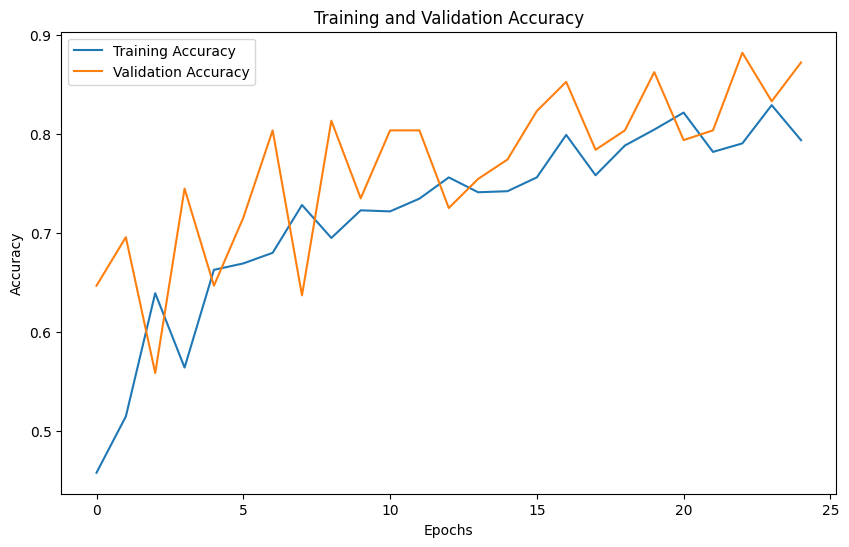

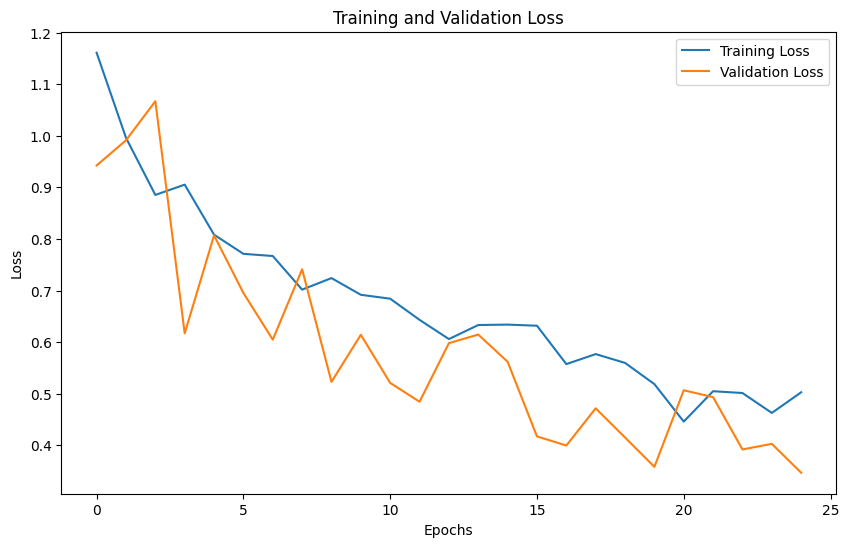

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 


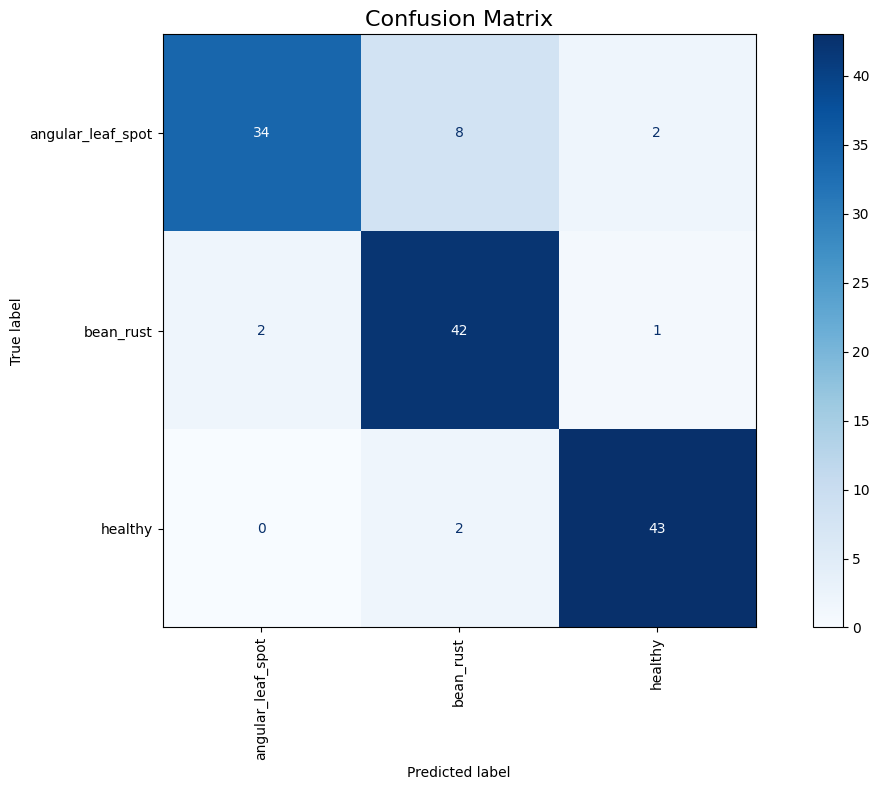

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
    self._run_once()
  File "/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/asyncio/base_events.py", line 1977, in _run_on

In [20]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 1"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 2

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1735003393.416935   22209 service.cc:148] XLA service 0x7fa9ac007920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735003393.417083   22209 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-24 08:23:14.382121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735003398.074424   22209 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1735003414.175015   22209 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735003414.409194   22209 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735003414.661837   22

 2/30 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.3594 - loss: 1.2796 

E0000 00:00:1735003456.430937   22207 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735003456.700272   22207 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3516 - loss: 1.2940 - val_accuracy: 0.4804 - val_loss: 1.0342
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.5264 - loss: 1.0040 - val_accuracy: 0.6471 - val_loss: 1.1283
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.6133 - loss: 0.9100 - val_accuracy: 0.6275 - val_loss: 0.9498
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.6538 - loss: 0.8410 - val_accuracy: 0.7255 - val_loss: 0.6629
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.6499 - loss: 0.7823 - val_accuracy: 0.6961 - val_loss: 1.0032
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.7171 - loss: 0.6766 - val_accuracy: 0.7255 - val_loss: 0.7179
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.6956 - loss: 0.7768 - val_accuracy: 0.7745 - val_loss: 0.6220
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.7048 - loss: 0.6989 - val_accuracy: 0.6667 - val_l

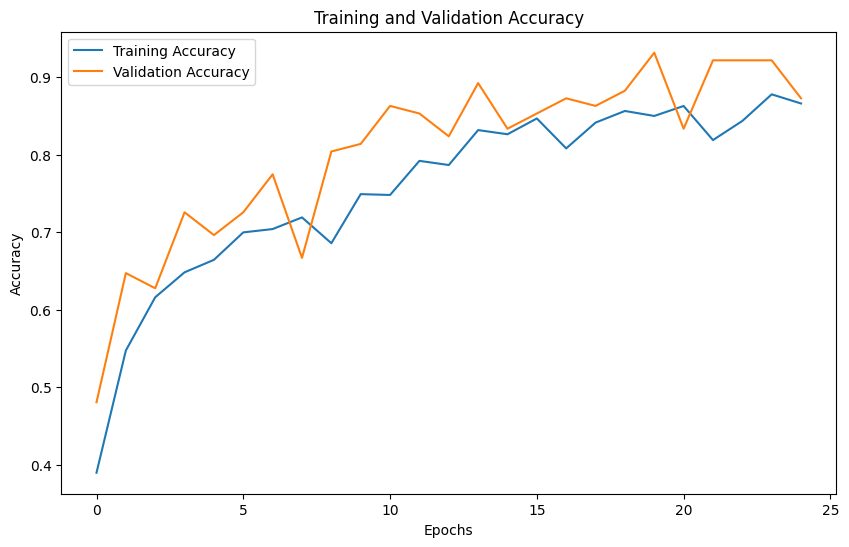

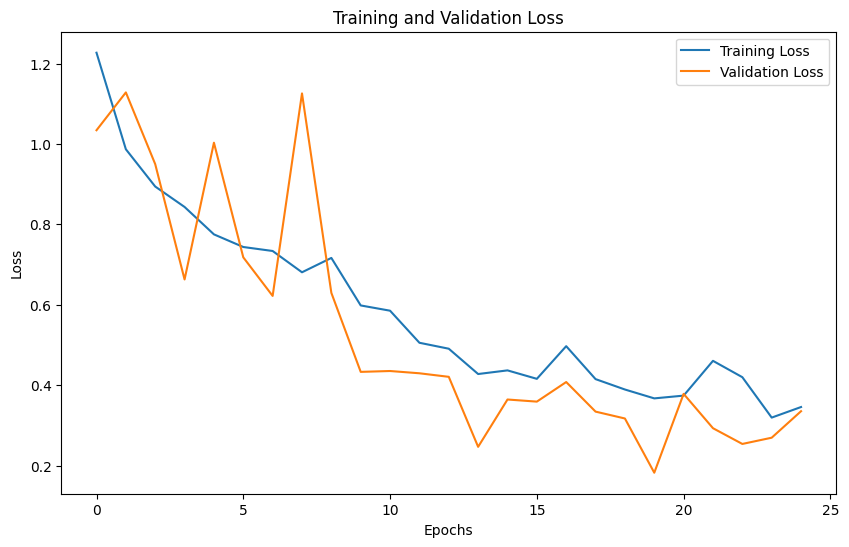

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step 


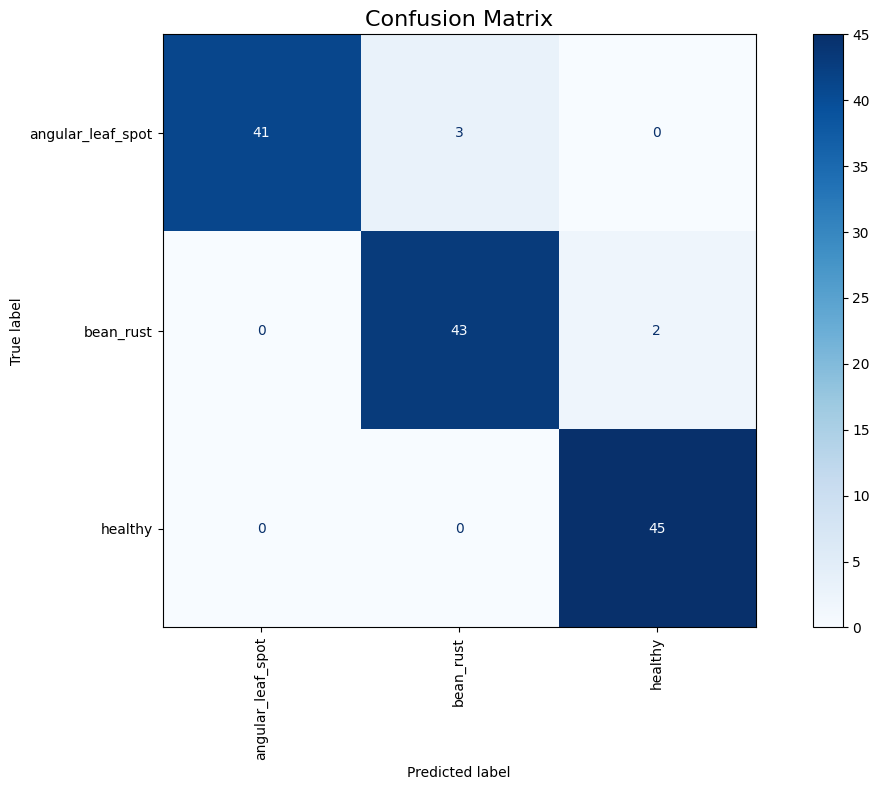

In [19]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 2"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 3

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3760 - loss: 1.1513 - val_accuracy: 0.5196 - val_loss: 1.3716
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.5653 - loss: 0.9263 - val_accuracy: 0.5784 - val_loss: 1.4453
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.6206 - loss: 0.8828 - val_accuracy: 0.6373 - val_loss: 0.7365
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.6486 - loss: 0.7918 - val_accuracy: 0.7255 - val_loss: 0.7422
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.6671 - loss: 0.7685 - val_accuracy: 0.7059 - val_loss: 0.8236
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.6360 - loss: 0.8341 - val_accuracy: 0.6863 - val_loss: 1.0038
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.6948 - loss: 0.6873 - val_accuracy: 0.7451 - val_loss: 0.6672
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.7105 - loss: 0.6600 - val_accuracy: 0.

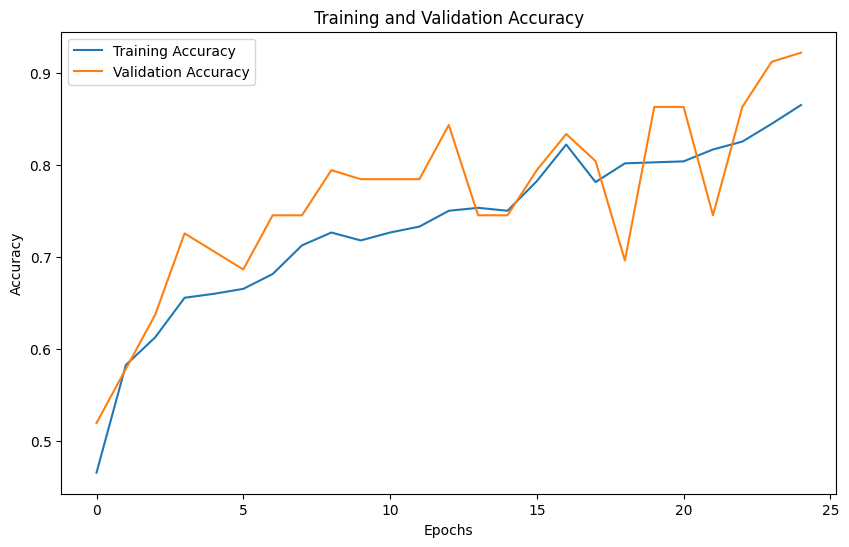

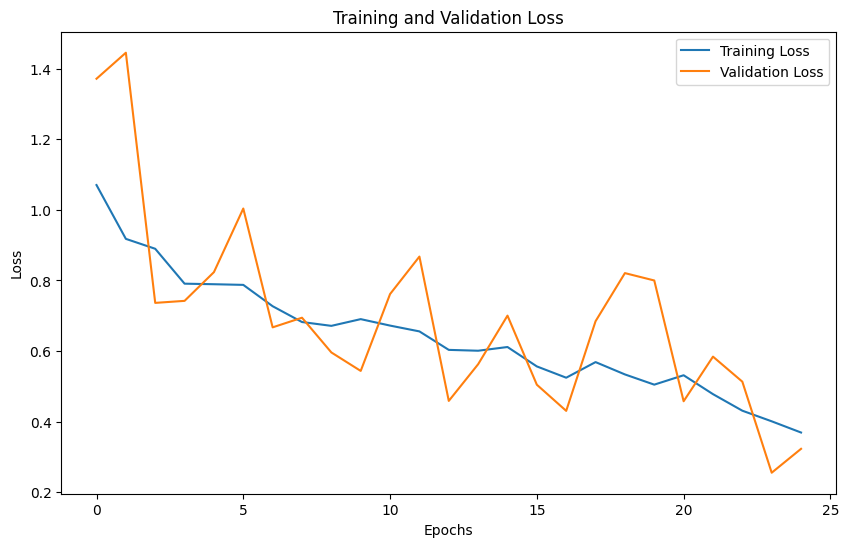

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step 


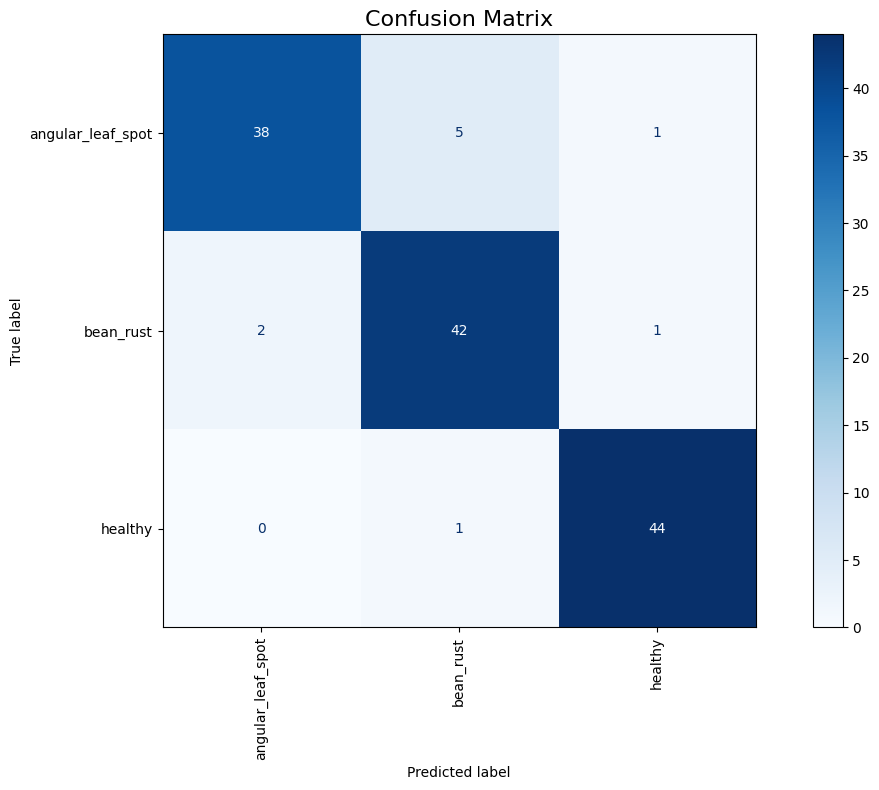

In [20]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 3"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 4

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4415 - loss: 1.0852 - val_accuracy: 0.5686 - val_loss: 1.0450
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.6120 - loss: 0.8919 - val_accuracy: 0.6569 - val_loss: 0.8784
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.6516 - loss: 0.8216 - val_accuracy: 0.6176 - val_loss: 0.7883
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.6707 - loss: 0.7886 - val_accuracy: 0.6176 - val_loss: 0.8431
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.6555 - loss: 0.8166 - val_accuracy: 0.6569 - val_loss: 1.4090
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.6799 - loss: 0.7521 - val_accuracy: 0.7255 - val_loss: 0.6421
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.6902 - loss: 0.7264 - val_accuracy: 0.7745 - val_loss: 0.6289
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.7133 - loss: 0.6949 - val_accuracy: 0.

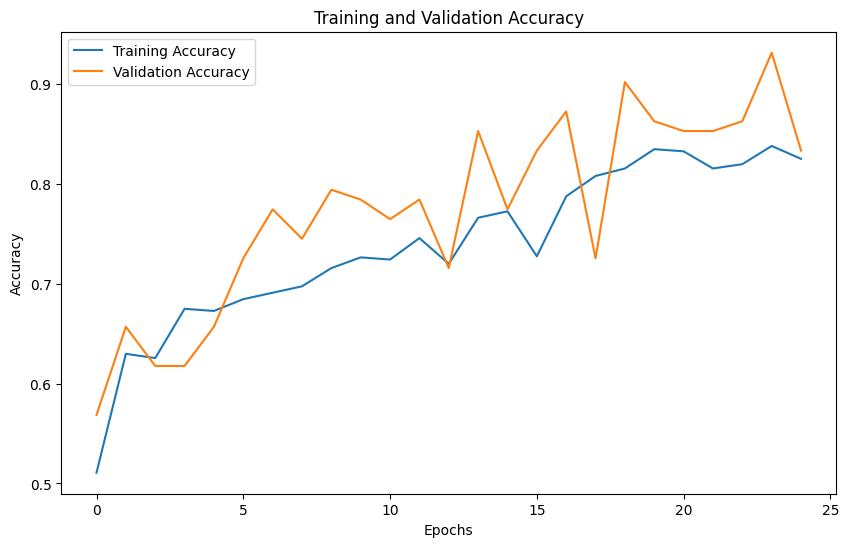

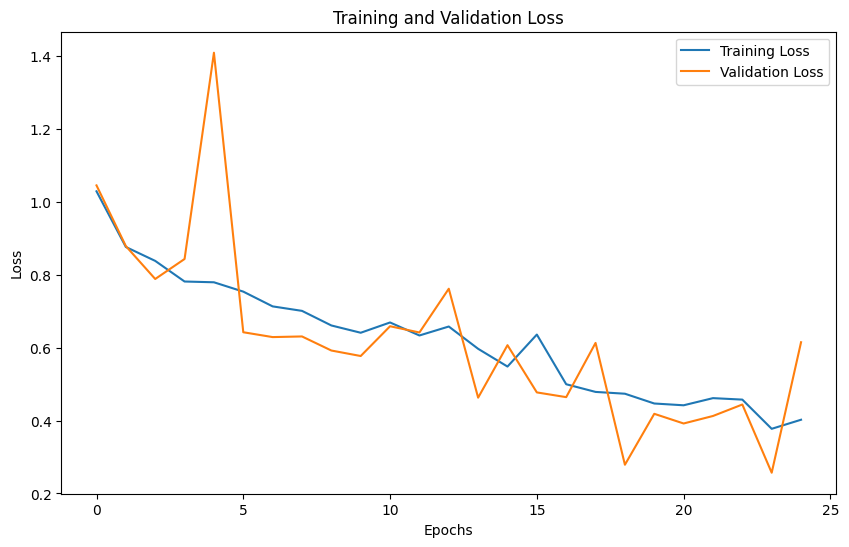

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step 


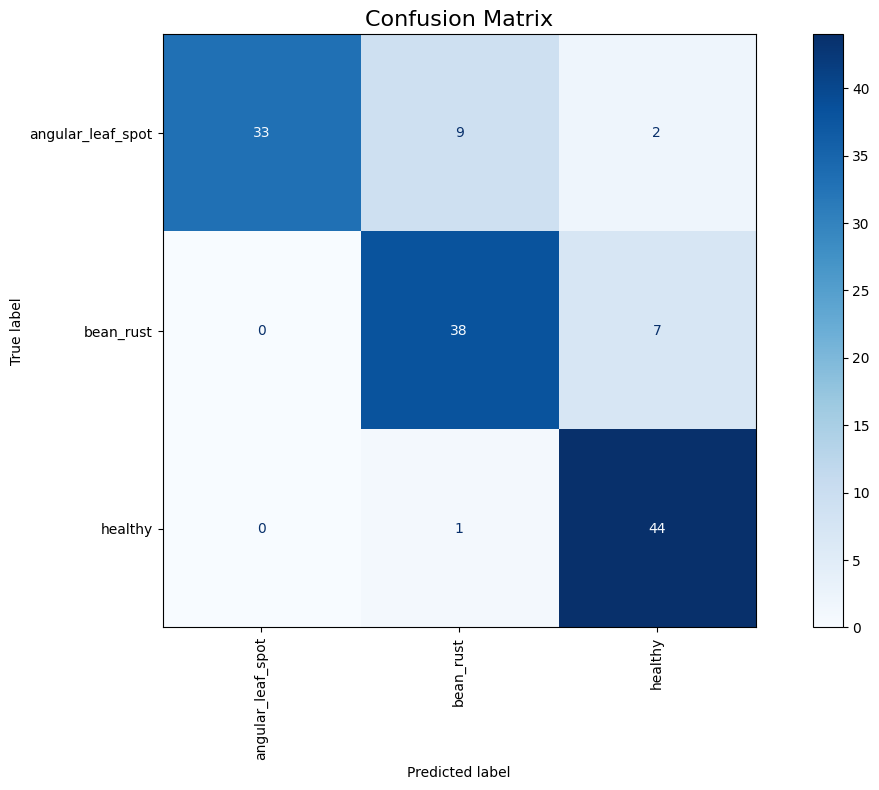

In [21]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 4"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 5

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4320 - loss: 1.1036 - val_accuracy: 0.6176 - val_loss: 0.8736
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.5564 - loss: 0.9954 - val_accuracy: 0.5686 - val_loss: 1.4005
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.6271 - loss: 0.8565 - val_accuracy: 0.7353 - val_loss: 0.7002
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.6659 - loss: 0.8875 - val_accuracy: 0.7255 - val_loss: 0.6519
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6752 - loss: 0.8290 - val_accuracy: 0.7157 - val_loss: 0.7287
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.6791 - loss: 0.7335 - val_accuracy: 0.7255 - val_loss: 0.6334
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.7238 - loss: 0.6464 - val_accuracy: 0.7255 - val_loss: 0.8411
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.6851 - loss: 0.7764 - val_accuracy: 0.59

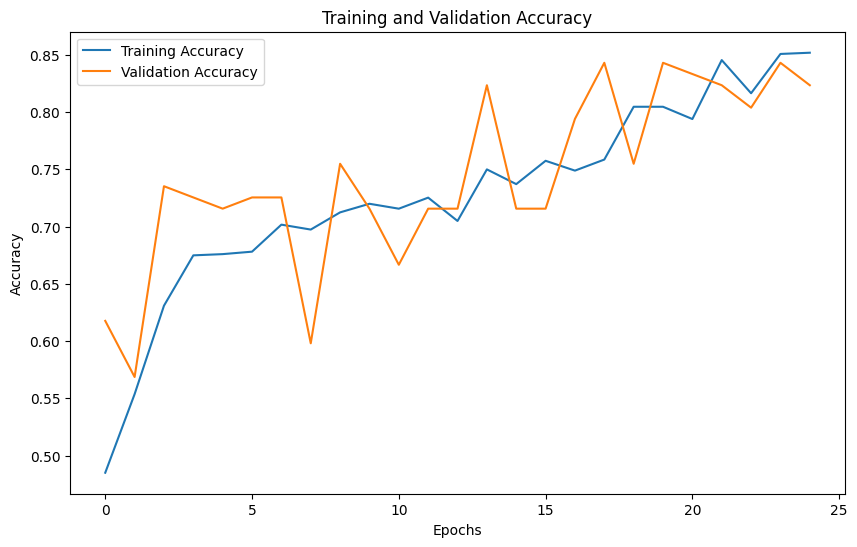

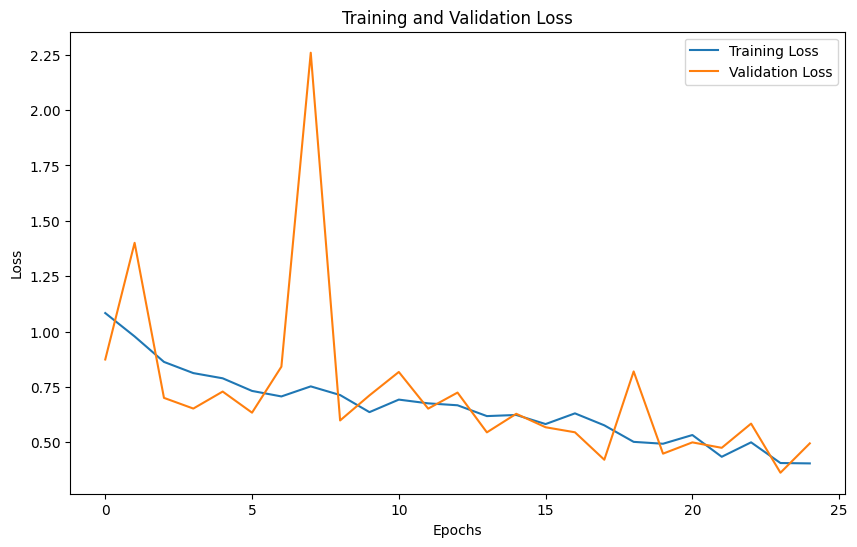

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step 


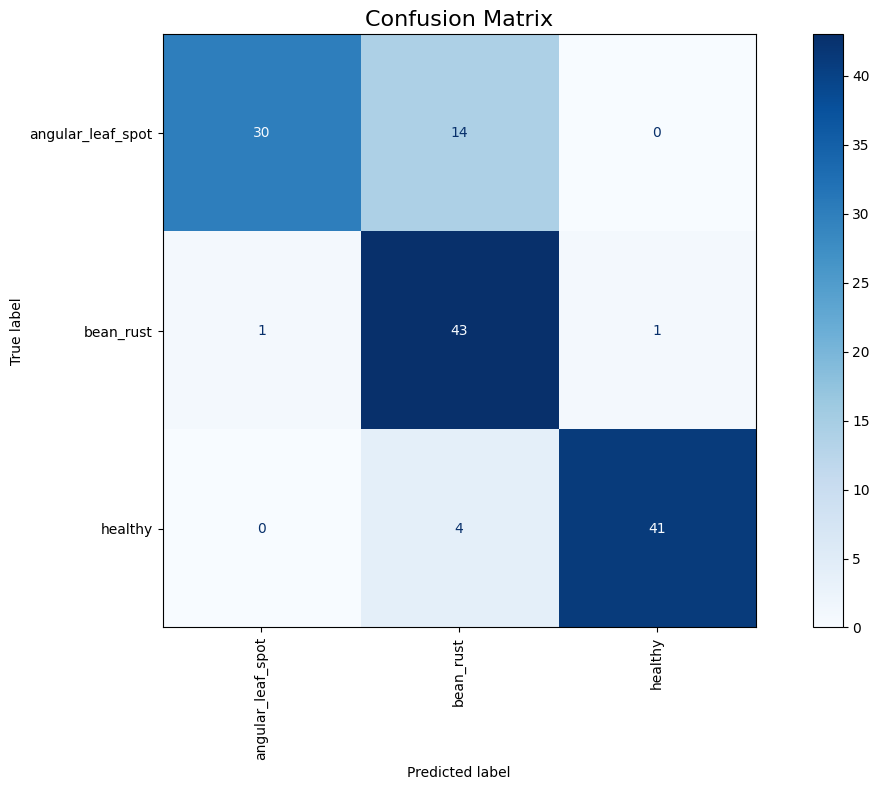

In [22]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 5"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 6

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


I0000 00:00:1735005759.547732   30583 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1735005783.085425   30732 service.cc:148] XLA service 0x7f50b8003da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735005783.086183   30732 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-12-24 09:03:03.732686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735005786.081594   30732 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-24 09:03:16.382569: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[576,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,576,14,14]{3,2,1,0}, f32[32,576,14,14]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"

30/30 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.3760 - loss: 1.2032 - val_accuracy: 0.5196 - val_loss: 1.2260
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.5958 - loss: 0.9990 - val_accuracy: 0.6569 - val_loss: 0.8652
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6547 - loss: 0.7848 - val_accuracy: 0.7157 - val_loss: 0.7068
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.6771 - loss: 0.7946 - val_accuracy: 0.5980 - val_loss: 1.8548
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6519 - loss: 0.7972 - val_accuracy: 0.7059 - val_loss: 0.6916
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.6971 - loss: 0.7608 - val_accuracy: 0.6569 - val_loss: 1.0431
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.7089 - loss: 0.6896 - val_accuracy: 0.7255 - val_loss: 0.6544
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.7483 - loss: 0.6330 - val_accuracy: 0.6765 - val_lo

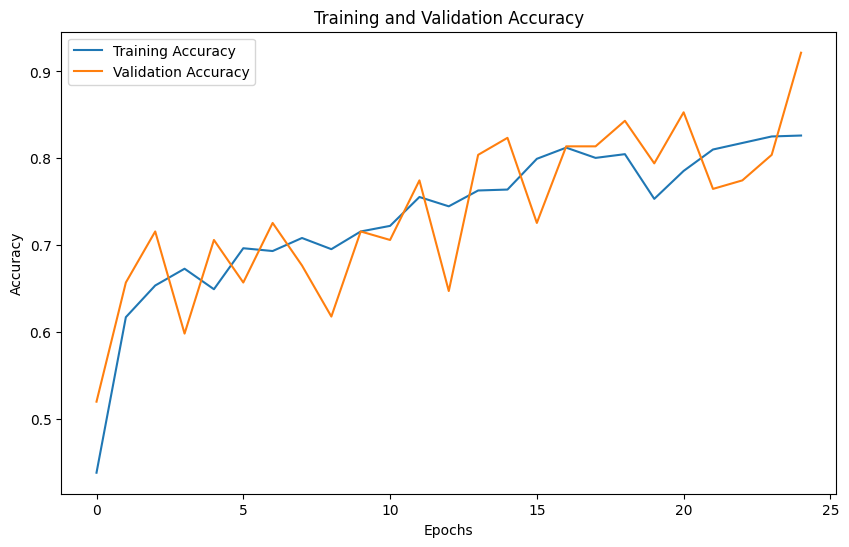

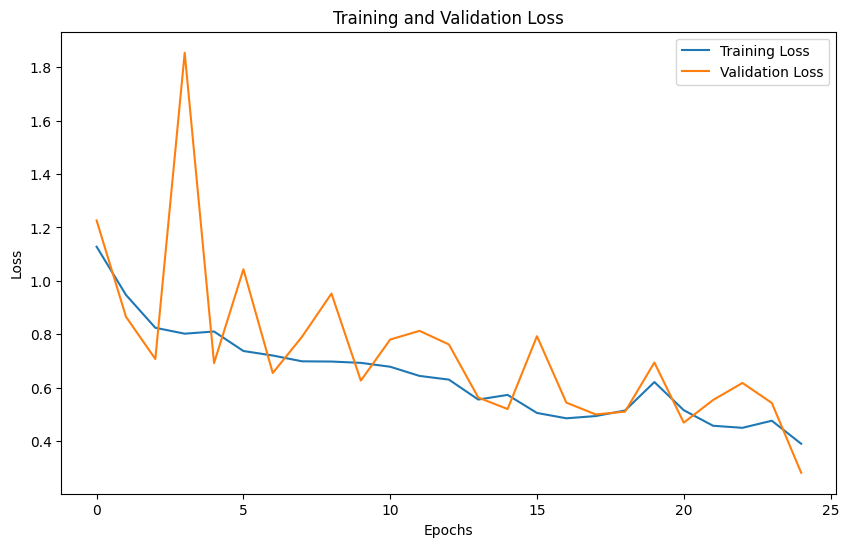

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


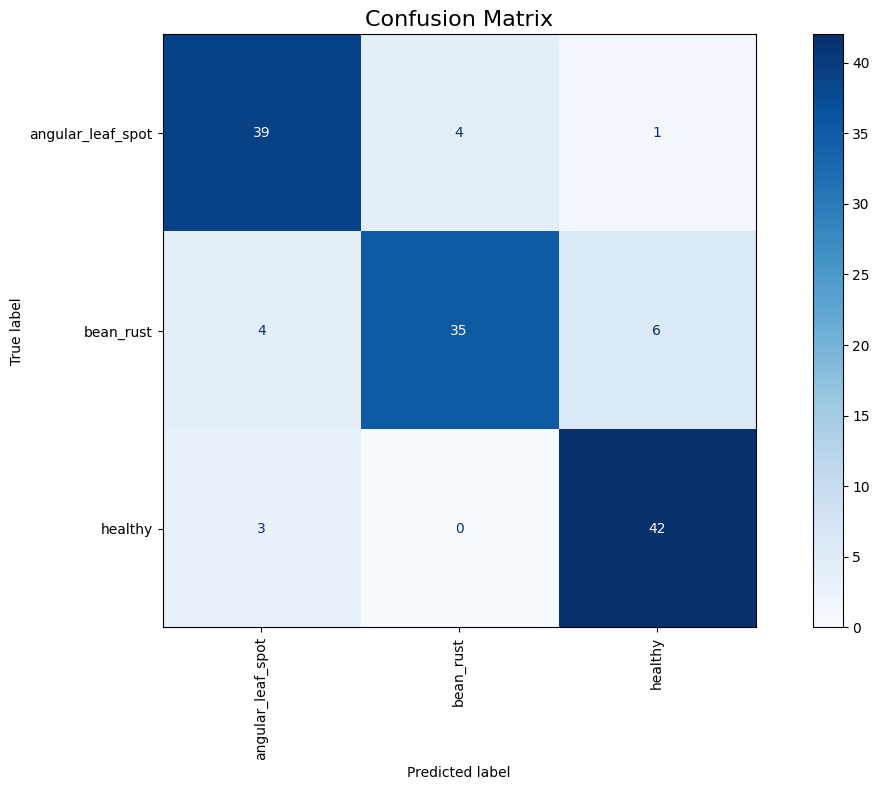

In [14]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 6"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 4 & 5

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


E0000 00:00:1735006121.517294   30732 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735006121.796466   30732 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735006122.085054   30732 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-12-24 09:08:42.138282: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[1152,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1152,14,14]{3,2,1,0}, f32[32,1152,14,14]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=1152, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_

30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4654 - loss: 1.0672 - val_accuracy: 0.6176 - val_loss: 0.8820
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.6599 - loss: 0.8116 - val_accuracy: 0.6961 - val_loss: 0.8112
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 274ms/step - accuracy: 0.6489 - loss: 0.8067 - val_accuracy: 0.6176 - val_loss: 0.9225
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.6840 - loss: 0.7720 - val_accuracy: 0.7059 - val_loss: 0.8967
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.6902 - loss: 0.7564 - val_accuracy: 0.6176 - val_loss: 0.8771
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step - accuracy: 0.6550 - loss: 0.8060 - val_accuracy: 0.7059 - val_loss: 0.7649
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.6703 - loss: 0.7516 - val_accuracy: 0.6765 - val_loss: 0.9194
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.6522 - loss: 0.7385 - val_accuracy: 0.7647 - val_lo

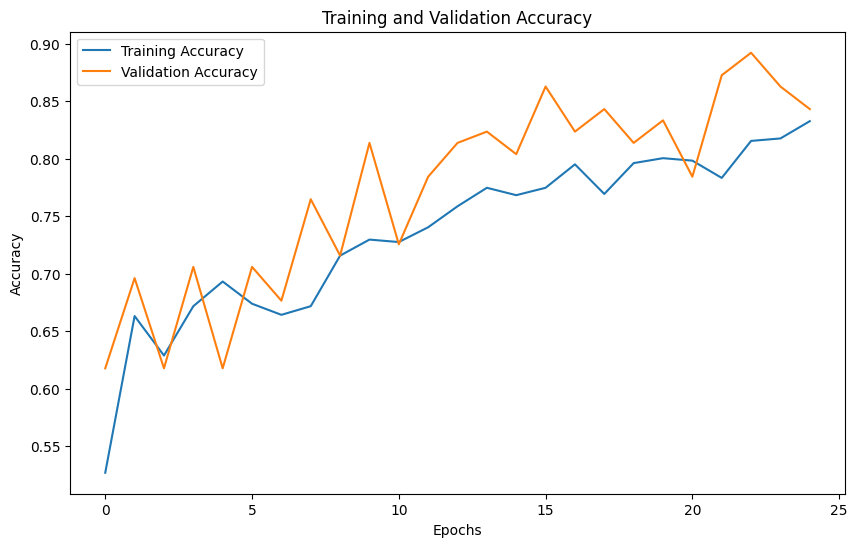

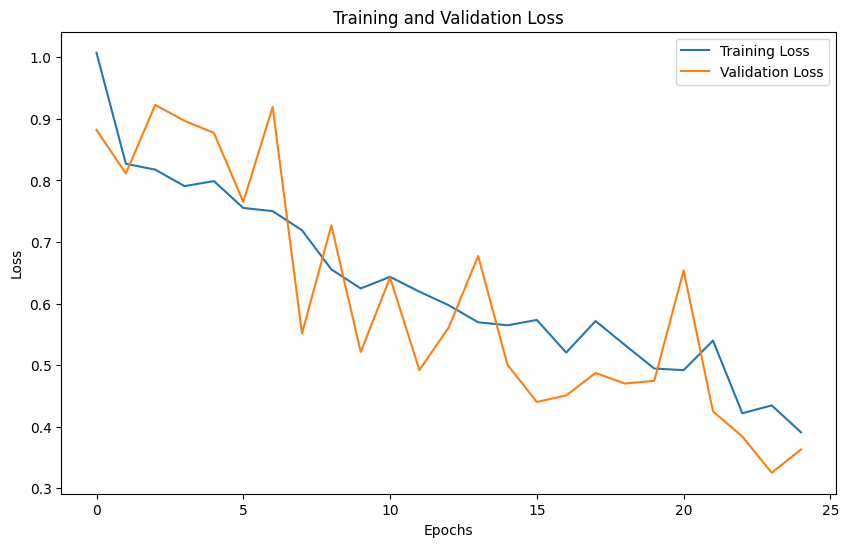

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 


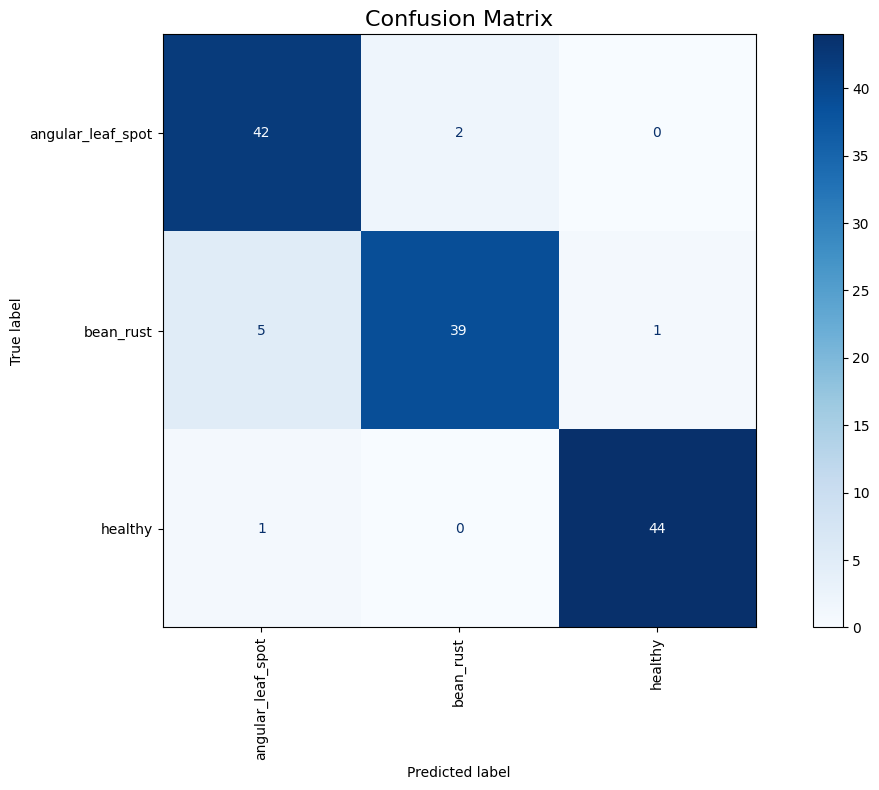

In [15]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 4 & 5"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 4 & 6

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


E0000 00:00:1735006492.907016   30728 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735006493.149853   30728 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


13/30 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.4258 - loss: 1.1406 

E0000 00:00:1735006513.781639   30732 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1735006514.050415   30732 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 967ms/step - accuracy: 0.4834 - loss: 1.0861 - val_accuracy: 0.6863 - val_loss: 0.7079
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.6130 - loss: 0.8474 - val_accuracy: 0.6373 - val_loss: 0.8205
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.6105 - loss: 0.8674 - val_accuracy: 0.7353 - val_loss: 0.7344
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6810 - loss: 0.7574 - val_accuracy: 0.7255 - val_loss: 0.7337
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.6351 - loss: 0.7778 - val_accuracy: 0.7745 - val_loss: 0.6761
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6950 - loss: 0.6761 - val_accuracy: 0.6275 - val_loss: 0.8148
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.6726 - loss: 0.7181 - val_accuracy: 0.7059 - val_loss: 0.6211
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.6676 - loss: 0.7278 - val_accuracy: 0.7157 - val

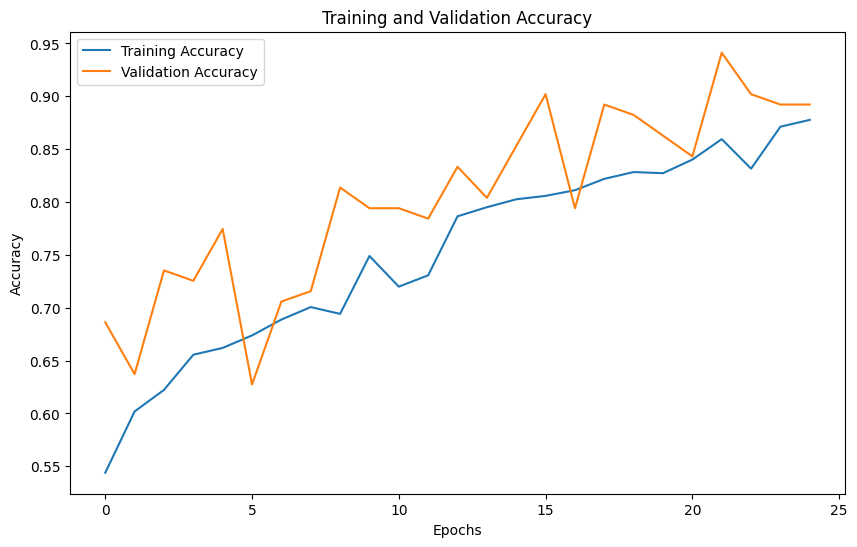

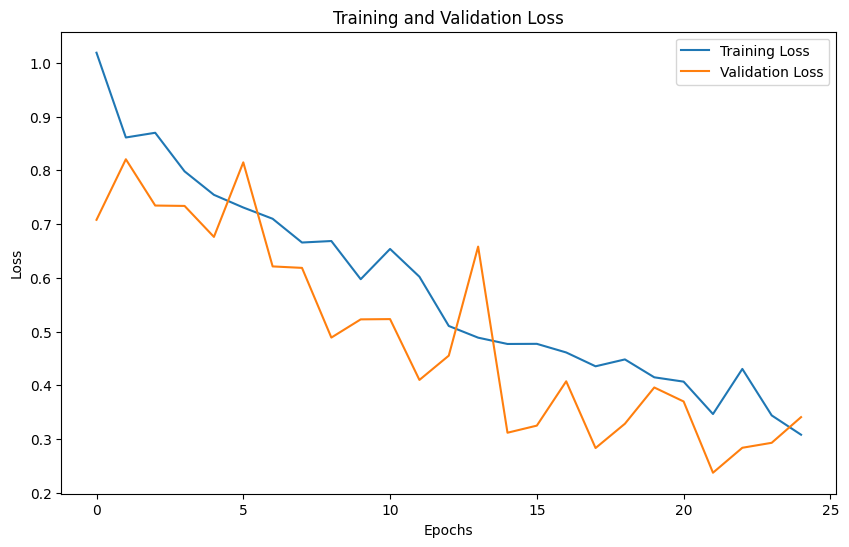

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 


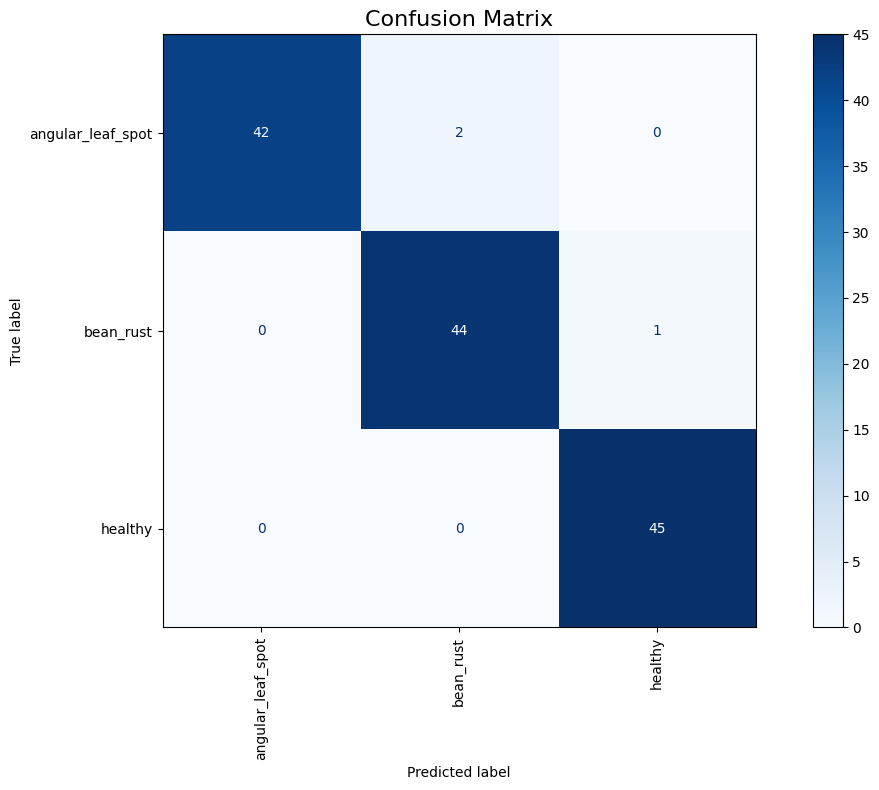

In [16]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 4 & 6"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

#### Delete Block 5 & 6

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/projectAI/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 769ms/step - accuracy: 0.4803 - loss: 1.0222 - val_accuracy: 0.5098 - val_loss: 1.0232
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.6093 - loss: 0.8719 - val_accuracy: 0.7255 - val_loss: 0.6842
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.6510 - loss: 0.7828 - val_accuracy: 0.7255 - val_loss: 0.6743
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6663 - loss: 0.7494 - val_accuracy: 0.8039 - val_loss: 0.5818
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.7049 - loss: 0.7104 - val_accuracy: 0.7745 - val_loss: 0.6800
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7059 - loss: 0.7058 - val_accuracy: 0.7353 - val_loss: 0.6480
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6970 - loss: 0.7230 - val_accuracy: 0.7647 - val_loss: 0.6667
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.6977 - loss: 0.7308 - val_accuracy: 0

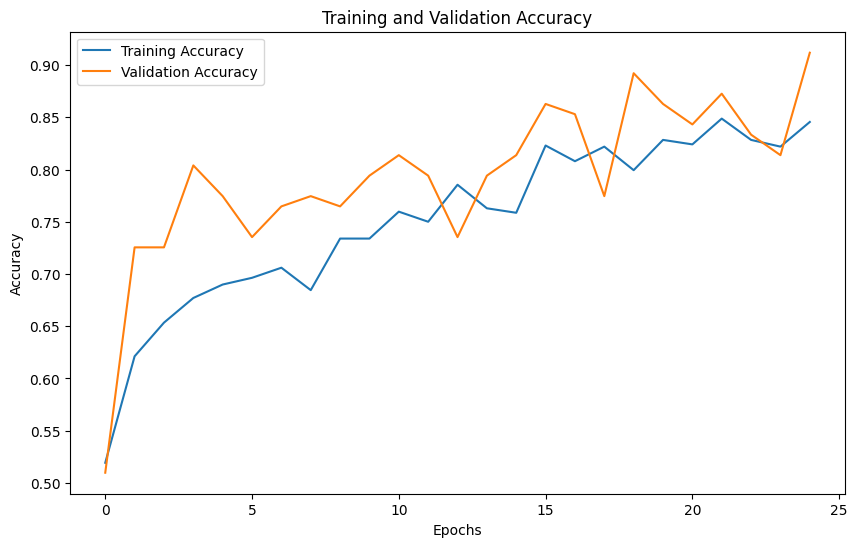

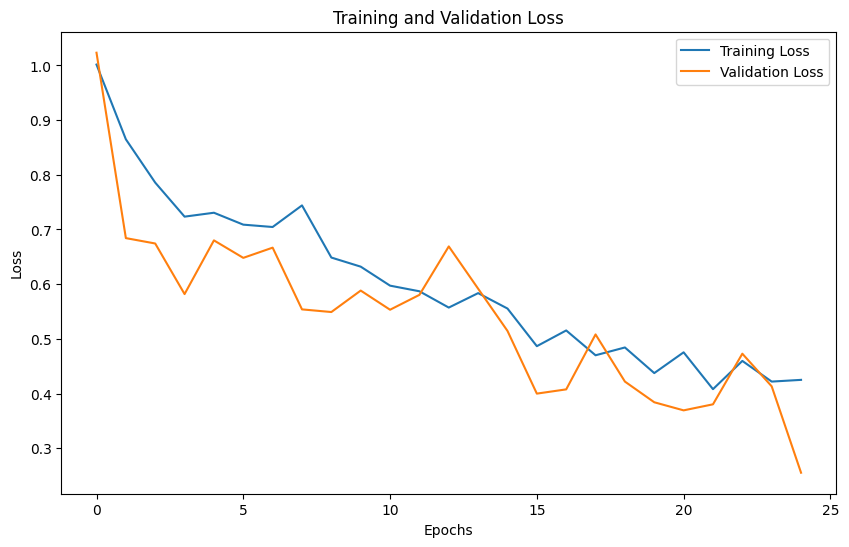

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 


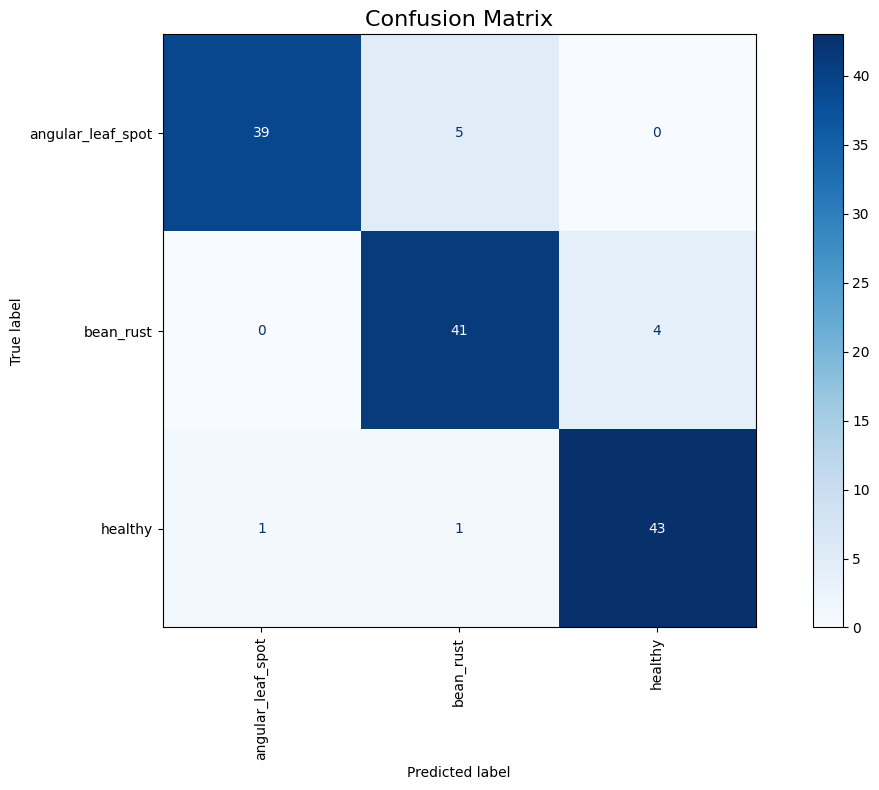

In [17]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 5 & 6"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)

# Delete

Found 932 images belonging to 3 classes.
Found 102 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


I0000 00:00:1736079138.580918   42827 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:52:00.0, compute capability: 8.6
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1736079156.178892   43477 service.cc:148] XLA service 0x727d44018bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736079156.178952   43477 service.cc:156]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-01-05 12:12:36.596305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736079158.149496   43477 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-05 12:12:39.522352: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2025-01-05 12:12:44.358749: I e

 2/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2031 - loss: 1.1999  

I0000 00:00:1736079179.199936   43477 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4164 - loss: 1.1608 - val_accuracy: 0.5784 - val_loss: 1.5812
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.5771 - loss: 0.9215 - val_accuracy: 0.7353 - val_loss: 0.6443
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 729ms/step - accuracy: 0.6522 - loss: 0.7976 - val_accuracy: 0.7255 - val_loss: 0.6838
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.6883 - loss: 0.7549 - val_accuracy: 0.7255 - val_loss: 0.6062
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 546ms/step - accuracy: 0.7032 - loss: 0.7213 - val_accuracy: 0.6765 - val_loss: 0.6815
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 664ms/step - accuracy: 0.7121 - loss: 0.7081 - val_accuracy: 0.7745 - val_loss: 0.5552
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 605ms/step - accuracy: 0.7521 - loss: 0.5887 - val_accuracy: 0.7157 - val_loss: 0.6015
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.7590 - loss: 0.5847 - val_accuracy: 0.7353 -

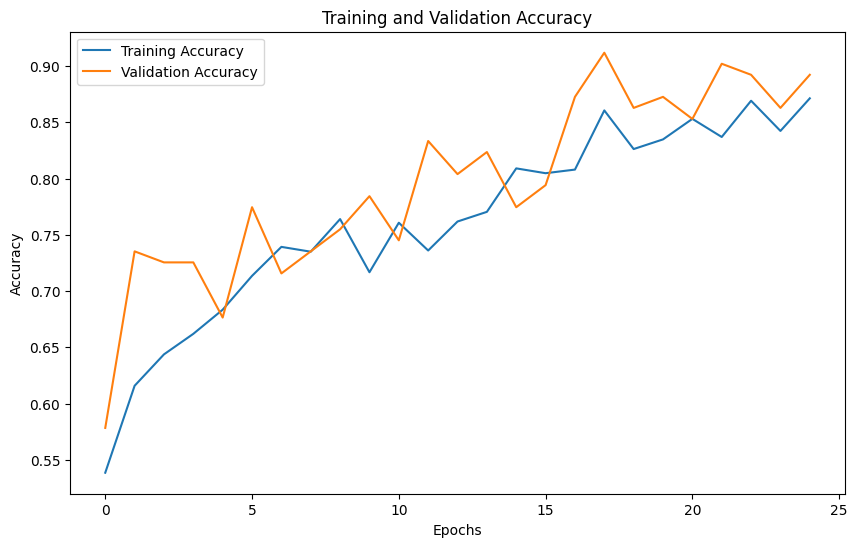

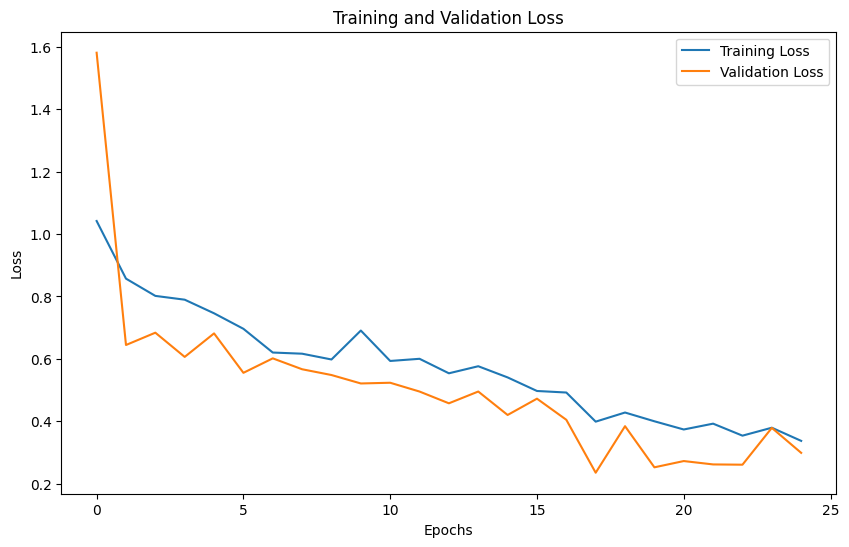

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step


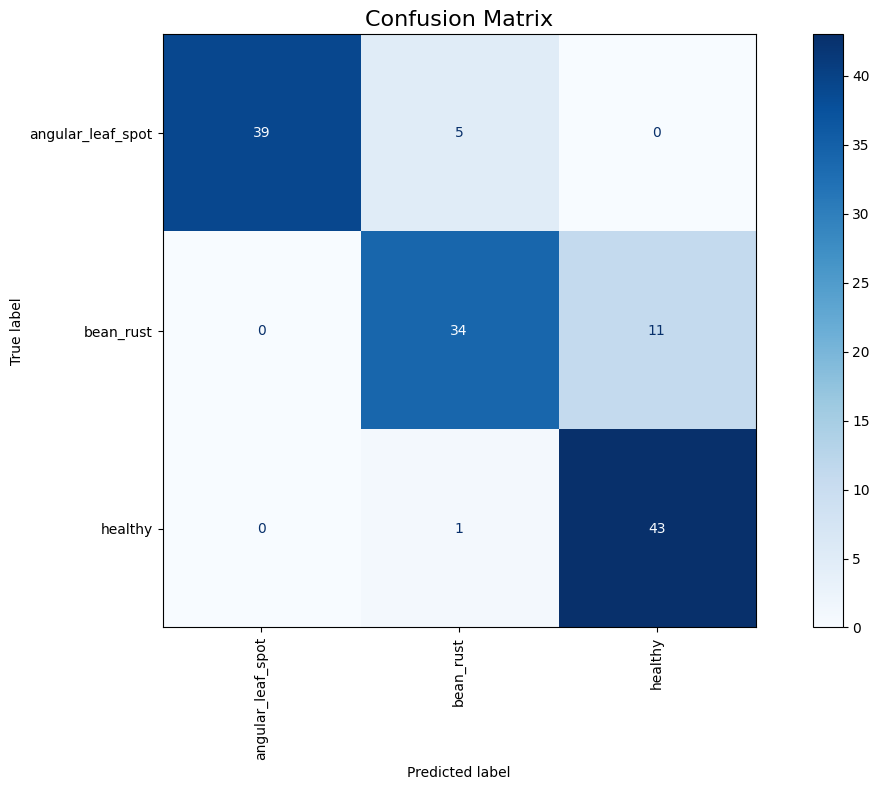

In [14]:
reload()
model_name = "EfficientNetV2B0Modifikasi"
skema = "Delete Block 4 & 6"

img_height, img_width = input_shapes[model_name]

train_generator,val_generator,test_generator = augmentation_generator_ENV2(img_height,img_width)

# Load base model
model = load_base_model(model_name, img_height, img_width, trainable_percentage_modifikasi, skema)

# Train model
history, image_path, timestamp, model, training_duration, test_accuracy = run_training(model)

# Plot history
plot_history(history, image_path, timestamp, model, training_duration, test_accuracy)